In [1]:
import nocd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix
import pandas as pd

import dgl
import numpy as np
import torch as th
from dgl.nn import EdgeGATConv

%matplotlib inline

torch.set_default_tensor_type(torch.cuda.FloatTensor)

c:\Users\User\anaconda3\envs\prodg\lib\site-packages\torch\__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [12]:
# df1=pd.read_csv('./dataset/ogbn_proteins/raw/edge.csv.gz')
# df2=pd.read_csv('./dataset/ogbn_proteins/raw/node_species.csv.gz')
# df3=pd.read_csv('./dataset/ogbn_proteins/raw/node-label-modified.csv.gz')
# df4=pd.read_csv('./dataset/ogbn_proteins/raw/edge-feat.csv.gz')

In [13]:
# graph = dgl.graph((df1['1'], df1['96401']))

In [14]:
# graph.ndata['feature']=torch.tensor(df3.iloc[:,:].values)
# graph.edata['feature']=torch.tensor(df4.iloc[:,:].values)

In [15]:
# import pickle

# with open('graph.pkl', 'wb') as file:
#     pickle.dump(graph, file)


In [2]:
import pickle
with open('graph.pkl', 'rb') as file:
    graph = pickle.load(file)

In [3]:
import networkx as nx
G=dgl.to_networkx(graph)
# A=nx.to_scipy_sparse_matrix(G, format='csr')
# A

In [4]:
with open('A.pkl', 'rb') as file:
    A = pickle.load(file)

In [5]:
# Load the CSV file into a DataFrame
df = pd.read_csv('./dataset/ogbn_proteins/raw/node_species.csv.gz', header=None, names=['species_id'])

# Reset index to make node id a column
df.reset_index(inplace=True)

# Create binary columns for each species using get_dummies
affiliation_matrix = pd.get_dummies(df, columns=['species_id'], prefix='', prefix_sep='').groupby('index').max()

In [6]:
Z_gt=affiliation_matrix.astype('int').values
# orG = G
N, K = Z_gt.shape

In [26]:
in_feats=112
edge_feats=8
out_feats=8
num_heads=1
feat_drop=0.5
attn_drop=0.5
negative_slope=0.2
residual=True
activation=F.relu
allow_zero_in_degree=True
bias=False
hidden_feats = [32]

In [27]:
hidden_sizes = [32]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0.5           # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 500        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000   # batch size (only for stochastic training)

In [28]:
sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
gnn = nocd.nn.EGCN(in_feats,
        edge_feats,
        hidden_sizes,
        out_feats,
        num_heads,
        feat_drop,
        attn_drop,
        negative_slope,
        residual,
        activation,
        allow_zero_in_degree,
        bias,
        dropout, 
        batch_norm).cuda()
adj_norm = gnn.normalize_adj(A)
decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
opt = torch.optim.Adam(gnn.parameters(), lr=lr)

In [10]:
gnn

EGCN(
  (edge_gat_conv): EdgeGATConv(
    (fc): Linear(in_features=112, out_features=32, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
    (res_fc): Linear(in_features=112, out_features=32, bias=False)
    (fc_edge): Linear(in_features=8, out_features=32, bias=False)
  )
  (gat_conv): GATConv(
    (fc): Linear(in_features=32, out_features=8, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
)

In [29]:
graph.ndata['feature']=graph.ndata['feature'].to(torch.float32)
graph.edata['feature']=graph.edata['feature'].to(torch.float32)

In [30]:
node_feats=graph.ndata['feature']
edge_feats=graph.edata['feature']

In [31]:
graph=graph.to('cuda')
node_feats=node_feats.cuda()
edge_feats=edge_feats.cuda()

In [32]:
node_feats=F.normalize(node_feats)
edge_feats=F.normalize(edge_feats)

In [33]:
def get_nmi(thresh=0.5):
    """Compute Overlapping NMI of the communities predicted by the GNN."""
    gnn.eval()
    Z = F.relu(gnn(graph, node_feats, edge_feats))
    Z=Z.reshape(Z.shape[0],Z.shape[3])
    Z_pred = Z.cpu().detach().numpy() > thresh
    nmi = nocd.metrics.overlapping_nmi(Z_pred, Z_gt)
    return nmi

In [27]:
Z = F.relu(gnn(graph, node_feats, edge_feats))
Z.shape

torch.Size([132534, 1, 1, 8])

In [ ]:
# for epoch, batch in enumerate(sampler):
#     print()

In [34]:
val_loss = np.inf
validation_fn = lambda: val_loss
early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
model_saver = nocd.train.ModelSaver(gnn)

for epoch, batch in enumerate(sampler):
    if epoch > max_epochs:
        break
    if epoch % 25 == 0:
        with torch.no_grad():
            gnn.eval()
            # Compute validation loss
            Z = F.relu(gnn(graph, node_feats, edge_feats))
            Z=Z.reshape(Z.shape[0],Z.shape[3])
            val_loss = decoder.loss_full(Z, A)
            print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {get_nmi():.4f}')
            
            # Check if it's time for early stopping / to save the model
            early_stopping.next_step()
            if early_stopping.should_save():
                model_saver.save()
            if early_stopping.should_stop():
                print(f'Breaking due to early stopping at epoch {epoch}')
                break
            
    # Training step
    gnn.train()
    opt.zero_grad()
    Z = F.relu(gnn(graph, node_feats, edge_feats))
    Z=Z.reshape(Z.shape[0],Z.shape[3])
    ones_idx, zeros_idx = batch
    if stochastic_loss:
        loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
    else:
        loss = decoder.loss_full(Z, A)
    loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
    loss.backward()
    opt.step()

Epoch    0, loss.full = 5.7951, nmi = 0.0268


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.72 GiB. GPU 0 has a total capacity of 11.99 GiB of which 0 bytes is free. Of the allocated memory 34.31 GiB is allocated by PyTorch, and 3.89 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

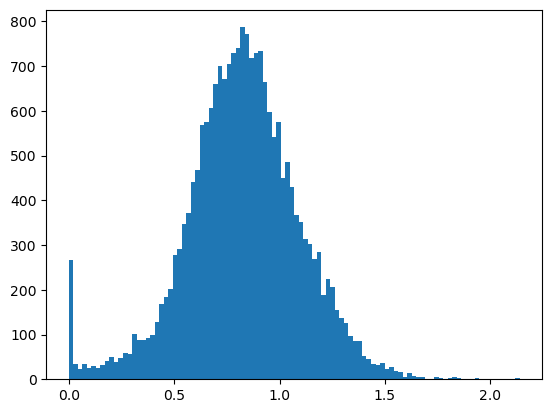

In [ ]:
plt.hist(Z[Z > 0].cpu().detach().numpy(), 100);

In [ ]:
thresh = 0.5

Z = F.relu(gnn(graph, node_feats, edge_feats))
Z= Z.view(-1, Z.size(2))
Z_pred = Z.cpu().detach().numpy() > thresh
model_saver.restore()
print(f'Final nmi = {get_nmi(thresh):.3f}')

Final nmi = 0.006


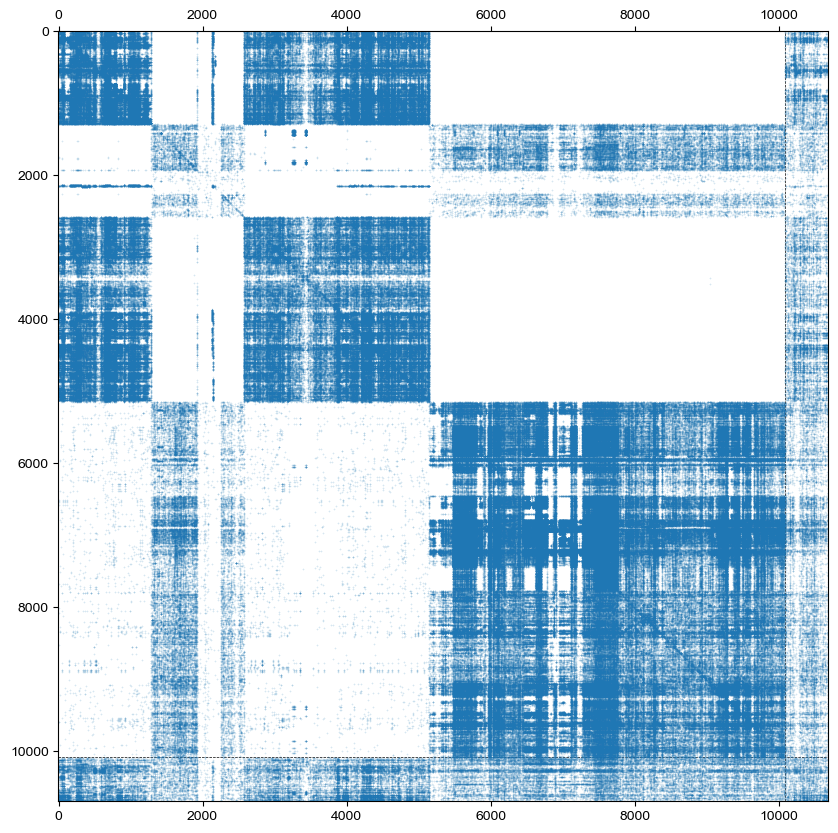

In [ ]:
plt.figure(figsize=[10, 10])
z = np.argmax(Z_pred, 1)
o = np.argsort(z)
nocd.utils.plot_sparse_clustered_adjacency(A, K, z, o, markersize=0.05)

In [ ]:
# Sizes of detected communities
print(Z_pred.sum(0))

[9437 9666]


In [ ]:
metrics = nocd.metrics.evaluate_unsupervised(Z_gt, A)
print(f"Ground truth communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

c:\Users\ACT\Desktop\overlapping-community-detection\nocd\metrics\unsupervised.py:29: RuntimeWarning: overflow encountered in scalar multiply
  possible = (n - 2) * (n - 1) * n / 6


Ground truth communities:
 - coverage    = 0.9962
 - conductance = 0.0040
 - density     = 2.517e-02
 - clust_coef  = 0.000e+00


In [ ]:
metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
print(f"Predicted communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

Predicted communities:
 - coverage    = 0.9806
 - conductance = 0.0432
 - density     = 1.497e-02
 - clust_coef  = 0.000e+00


In [ ]:
Z_gt

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [ ]:
Z_pred

array([[False, False],
       [ True,  True],
       [ True,  True],
       ...,
       [False, False],
       [ True,  True],
       [False, False]])

In [ ]:
different_values_count = np.sum(Z_pred[:, 0] != Z_pred[:, 1])
different_values_count

987

In [ ]:
def get_comlist(community_matrix):
    transposed_matrix = np.transpose(community_matrix)

    # Initialize an empty list to store tuples (community_id, nodes_list)
    community_nodes_list = []

    # Iterate through rows (communities)
    for community_id, community_row in enumerate(transposed_matrix):
        # Find nodes (columns) where the value is 1
        community_nodes = np.where(community_row == 1)[0].tolist()
        
        # Append a tuple to the list containing community ID and nodes list
        community_nodes_list.append(community_nodes)
    
    return community_nodes_list

In [ ]:
from cdlib import algorithms

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'wurlitzer', 'bayanpy', 'leidenalg', 'infomap'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'leidenalg'}


In [ ]:
from cdlib import NodeClustering
from cdlib import evaluation

coms1=get_comlist(Z_gt)
coms2=get_comlist(Z_pred)

communities1=NodeClustering(coms1,G)
communities2=NodeClustering(coms2,G)

onmi=evaluation.overlapping_normalized_mutual_information_LFK(communities1,communities2)
print(onmi)

MatchingResult(score=0.011492006072273186, std=None)
